<a href="https://colab.research.google.com/github/haesookimDev/FLSMal/blob/main/ExtractFeatureFromCNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manyl

In [38]:
import pandas as pd
import torch
import numpy as np
import os

In [4]:
import pytorch_lightning as pl

In [5]:
!pwd

/content


In [6]:
%cd drive/MyDrive/FSLMal

/content/drive/MyDrive/FSLMal


In [7]:
!ls

CustomDataset.py  data_labelFSL.csv  logs		     __pycache__
Data		  Data.zip	     MalClassifierForFSL.py  TrainCNNForFSL.ipynb


In [10]:
from MalClassifierForFSL import MalClassifierForFSL

In [9]:
hyper_parameter = {
    'max_length': 2000,
    'lr': 1e-3,  # Starting Learning Rate
    'epochs' : 50,
    'optimizer' : 'adamw',
    'gamma' : 1,
    'batch_size': 64,
    'DataFrame': pd.read_csv("./data_labelFSL.csv"),
    "class_num": 9,
    "static_path": "./Data/Data/img/",
    "dynamic_path": "./Data/Data/tfidf",
    "img_type": 'orig'
}

In [16]:
model = MalClassifierForFSL(hyper_parameter)

In [65]:
def forward(self, dy, st):
    x2,_ = self.LSTM_DYNAMIC(dy)
    x2 = x2.reshape(x2.size(0), -1)
    x1 = self.CNN_STATIC(st)
    x1 = x1.reshape(x1.size(0), -1)

    return x1, x2

In [66]:
model.forward = forward

In [23]:
model.forward??

In [24]:
saved_state_dict = torch.load('./logs/lightning_logs/version_2/checkpoints/epoch=49-step=750.ckpt')

In [ ]:
saved_state_dict['state_dict']

In [26]:
current_state_dict = model.state_dict()

In [ ]:
current_state_dict

In [36]:
for key, value in saved_state_dict['state_dict'].items():
    current_state_dict[key] = value

In [37]:
model.freeze() #출력하는 과정에서 모델 파라미터 조정안됨

In [47]:
def data_path(datalist):
    image_paths = []
    tfidf_paths = []
    class_labels = []
    for idx, i in datalist.iterrows():
        datanumpy_tfidf = str(i['hash'])+'.npy'
        datanumpy_img = str(i['hash'])+'.png'
        image_paths += [os.path.join(model.STATIC_PATH, model.IMG_TYPE, datanumpy_img)]
        tfidf_paths += [os.path.join(model.DYNAMIC_PATH, str(model.MAX_LENGTH), datanumpy_tfidf)]

        class_labels += [i['label']]
    image_paths = np.array(image_paths)
    tfidf_paths = np.array(tfidf_paths)
    class_labels = np.array(class_labels)

    return image_paths, tfidf_paths, class_labels

In [50]:
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.mobilenet_v2 import preprocess_input

def _load_image(img_path):
    # load image from path and convert to array
    img = load_img(img_path, color_mode="grayscale")
    st_data = img_to_array(img)
    img = preprocess_input(st_data)

    return img

def _load_tfidf(tfidf_path):
    data = np.load(tfidf_path)

    return data


In [48]:
image_paths, tfidf_paths, class_labels = data_path(model.DATAFRAME.loc[ model.DATAFRAME['train']=='train'])

In [67]:
result = model(model, torch.Tensor([_load_tfidf(tfidf_paths[0])]), torch.Tensor(_load_image(image_paths[0])))

In [59]:
torch.Tensor(_load_tfidf(tfidf_paths[0])).size()

torch.Size([2000])

In [101]:
result[0].reshape(-1).size(0)

4224

In [109]:
result[1].reshape(-1).size(0)

240

In [120]:
data = [torch.cat((result[0].reshape(-1), result[1].reshape(-1))).tolist()]

In [156]:
def extractData(tfidf, image):
  result = model(model, torch.Tensor([_load_tfidf(tfidf)]), torch.Tensor(_load_image(image)))
  data = torch.cat((result[0].reshape(-1), result[1].reshape(-1))).tolist()
  return data

In [171]:
index = ['i_'+str(i) for i in range(result[0].reshape(-1).size(0))]

In [172]:
index.extend(['t_'+str(i) for i in range(result[1].reshape(-1).size(0))])

In [112]:
index.extend(['label'])

In [133]:
len(index)

4465

In [135]:
train_data = []

In [177]:
train_data = []
for i in range(len(class_labels)):
  data = extractData(tfidf_paths[i], image_paths[i])
  train_data.append(data)

In [176]:
len(train_data)

1800

In [164]:
class_labels=class_labels.tolist()

In [178]:
df =pd.DataFrame(data=train_data, columns=index)

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Columns: 4464 entries, i_0 to t_239
dtypes: float64(4464)
memory usage: 30.7 MB


In [180]:
df_test = df.copy()

In [182]:
df_test['label']=class_labels

In [184]:
df_test.to_csv('./extractTrainData.csv')

In [199]:
df_test.iloc[:, -1]

0      0
1      0
2      0
3      0
4      0
      ..
895    8
896    8
897    8
898    8
899    8
Name: label, Length: 900, dtype: int64

In [185]:
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib import pyplot as plt

In [186]:
n_components = 2

In [193]:
model_tsne = TSNE(n_components=n_components)

In [194]:
X_embedded = model_tsne.fit_transform(df_test.iloc[:, :-1])

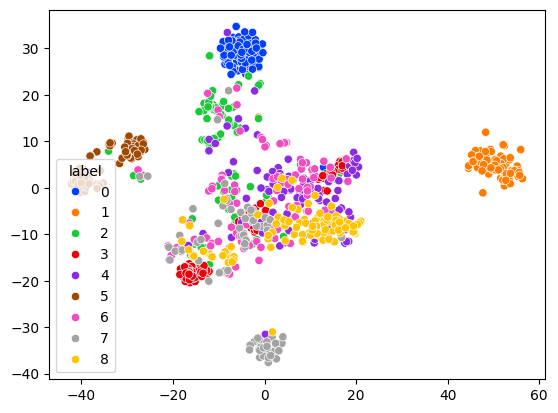

In [201]:
palette = sns.color_palette("bright", 9)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=df_test.iloc[:, -1], legend='full', palette=palette)
plt.show()